In [1]:
from projectFunctions import formatDataset
import os
import time

# Define file paths to training/testing set data
trainDataset = './ExampleSets/INRIAFullDataset/INRIAFullTrain.tar.gz'
testDataset = './ExampleSets/INRIAFullDataset/INRIAFullTest.tar.gz'

# Make folder to save graphs to if it doesn't exist already
graphFolder = './AblationImages'
if not os.path.isdir(graphFolder): os.mkdir(graphFolder)

print('Calculating HOG features...')
modelStartTime = time.time()
_, modelTrainFeatures, modelTrainLabels = formatDataset(
    trainDataset, 
    #blockDimensions = (3, 3), 
    deleteDir = True, 
    randomSeed = 48
)
_, modelTestFeatures, modelTestLabels = formatDataset(
    testDataset, 
    #blockDimensions = (3, 3), 
    deleteDir = True, 
    randomSeed = 48
)
print((
    'HOG features calculated; elapsed time = '
    f'{time.time() - modelStartTime:.2f} seconds'
))

Calculating HOG features...
HOG features calculated; elapsed time = 15.85 seconds


In [18]:
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

# Create and train SVM classifier
print('Training LinearSVC model...')
modelFitTime = time.time()
modelSVM = LinearSVC(penalty='l2', loss='squared_hinge', C=0.01, random_state = 48)
modelSVM.fit(modelTrainFeatures, modelTrainLabels)
print((
    'Training complete; elapsed time = '
    f'{time.time() - modelFitTime:.2f} seconds\n'
))

# Get predictions and decision function on the testing set
modelPredicts = modelSVM.predict(modelTestFeatures)
modelDecisions = modelSVM.decision_function(modelTestFeatures)

# Use iterator to calculate performance metrics with predictions
modelAccuracy = accuracy_score(modelTestLabels, modelPredicts)
modelPrecision = precision_score(modelTestLabels, modelPredicts)
modelRecall = recall_score(modelTestLabels, modelPredicts)
modelF1 = f1_score(modelTestLabels, modelPredicts)
modelAUC = roc_auc_score(modelTestLabels, modelDecisions)

# Compile performance metrics into Series
modelScores = pd.Series(
    (modelAccuracy, modelPrecision, modelRecall, modelF1, modelAUC), 
    index = ('Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC')
)

# Display DataFrame with caption
print('Performance Scores of HOG Features on INRIA Testing Dataset')
modelScores

Training LinearSVC model...
Training complete; elapsed time = 0.34 seconds

Performance Scores of HOG Features on INRIA Testing Dataset


Accuracy     0.977778
Precision    0.973568
Recall       0.982222
F1 Score     0.977876
AUC          0.997240
dtype: float64

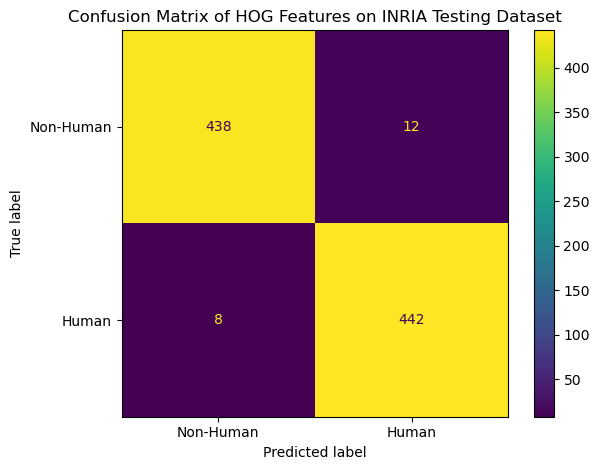

In [3]:
# Import confusion matrix and matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Display confusion matrix for default parameter model
ConfusionMatrixDisplay.from_predictions(
    modelTestLabels, modelPredicts, display_labels = ['Non-Human', 'Human']
)

plt.title('Confusion Matrix of HOG Features on INRIA Testing Dataset')
plt.tight_layout()
plt.savefig(os.path.join(graphFolder, 'final_matrix.png'))
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

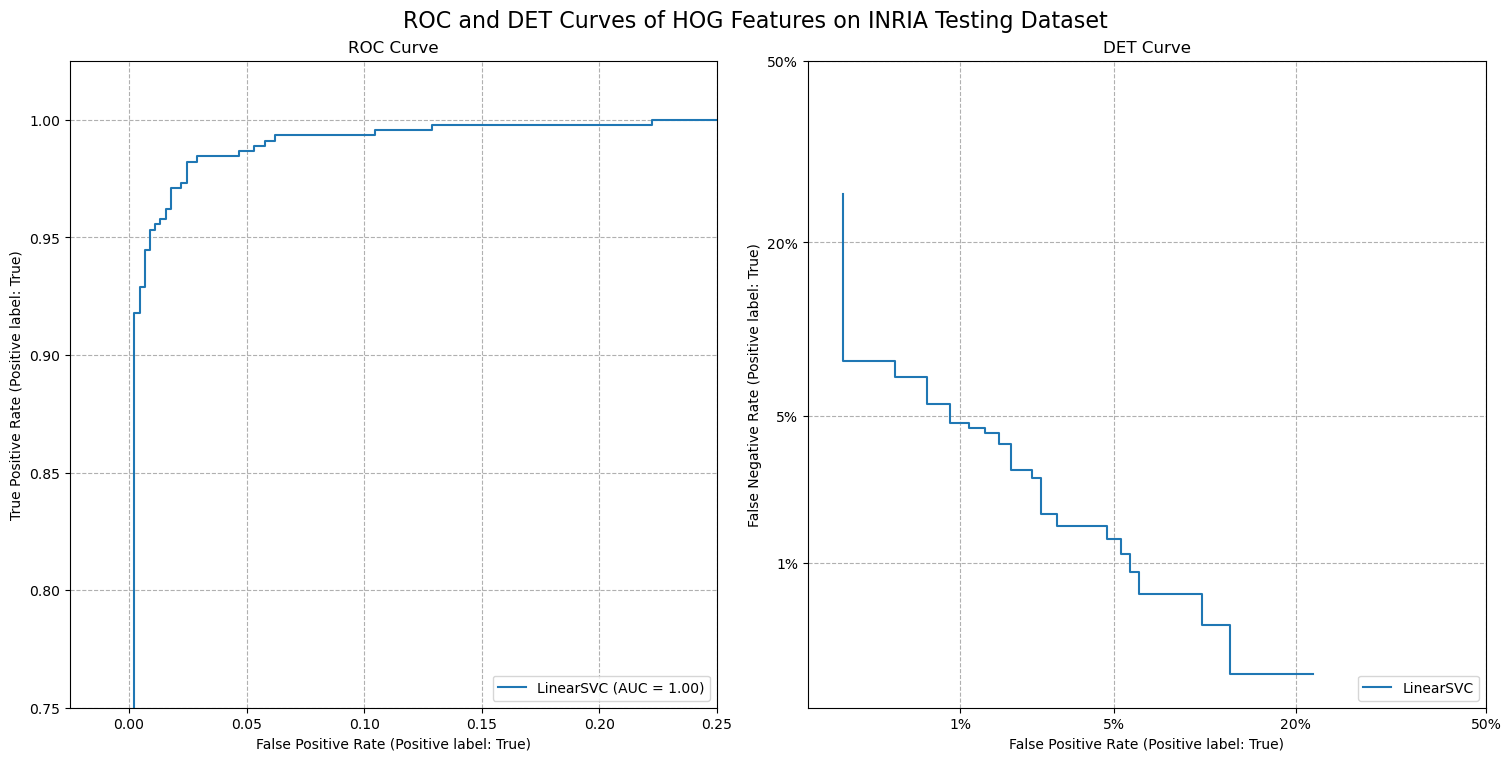

In [4]:
# Import ROC and DET curve functions
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

# Initialise curve figure
curveFigure, (rocAxes, detAxes) = plt.subplots(
    1, 2, figsize = (15,7.5), constrained_layout = True
)

# Generate ROC and DET curves for each normalisation technique
RocCurveDisplay.from_estimator(
    modelSVM, modelTestFeatures, modelTestLabels, ax=rocAxes
)
DetCurveDisplay.from_estimator(
    modelSVM, modelTestFeatures, modelTestLabels, ax=detAxes
)
rocAxes.grid(linestyle = "--") 
detAxes.grid(linestyle = "--") 

    
"""
    # Modify legend to avoid curve and label L2-Hys matrix as default
    labels = axis.get_legend_handles_labels()[1]
    labels[-1] = labels[-1].replace(
        'Normalisation', 'Normalisation (Default)'
    )
    axis.legend(
        labels = labels, 
        loc = 'upper right' if fn is DetCurveDisplay else 'lower right'
    )
"""

# Add titles and adjust limits for each axis
rocAxes.set_title('ROC Curve')
rocAxes.set_xlim([-0.025, 0.25])
rocAxes.set_ylim([0.75, 1.025])

detAxes.set_title('DET Curve')
detAxes.set_xlim([-3, 0])
detAxes.set_ylim([-3, 0])

# Set figure title
curveFigure.suptitle(
    'ROC and DET Curves of HOG Features on INRIA Testing Dataset', fontsize = 16
)

# Save curves as image
plt.savefig(os.path.join(graphFolder, 'final_curves.png'))

# Display ROC and DET curves
plt.show

In [5]:
# GRid SEarching

import os
import shutil
import tarfile
import joblib
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.utils import shuffle
from sklearn.feature_extraction.image import extract_patches_2d
from skimage.io import imread, imsave
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.feature import hog
"""
# Extract the images from the desired tarfile
with tarfile.open(trainDataset, 'r:gz') as tar:
    # Extract the images, recording the directory they are saved in
    imageDir = os.path.join('.', tar.getmembers()[0].name)
    tar.extractall()

    # Get list of image file paths
    imagePaths = np.array([
        os.path.join('.', img.name) for img in tar.getmembers()[1:]
    ])
with tarfile.open(testDataset, 'r:gz') as tar:
    # Extract the images, recording the directory they are saved in
    testImageDir = os.path.join('.', tar.getmembers()[0].name)
    tar.extractall()

    # Get list of image file paths
    testImagePaths = np.array([
        os.path.join('.', img.name) for img in tar.getmembers()[1:]
    ])
imageList, imageClasses, testImageList, testImageClasses = [], [], [], []
for path in imagePaths:
    # Read the image
    img = imread(path)
    
    # Resize to 64x128 pixels if needed
    if img.shape[0] != 128 or img.shape[1] != 64:
        img = resize(img, (128, 64), anti_aliasing=True)
    
    # Convert image to grayscale (handle both RGB and RGBA images)
    if len(img.shape) > 2:
        # For RGBA images (4 channels), remove the alpha channel first
        if img.shape[2] == 4: img = img[:, :, :3]
        grayImg = rgb2gray(img)
    else:
        grayImg = img

    flatImg = [element for lists in grayImg for element in lists]
    
    # Add to lists
    imageList.append(flatImg)
    imageClasses.append(os.path.basename(path).startswith('P'))

for path in testImagePaths:
    # Read the image
    img = imread(path)
    
    # Resize to 64x128 pixels if needed
    if img.shape[0] != 128 or img.shape[1] != 64:
        img = resize(img, (128, 64), anti_aliasing=True)
    
    # Convert image to grayscale (handle both RGB and RGBA images)
    if len(img.shape) > 2:
        # For RGBA images (4 channels), remove the alpha channel first
        if img.shape[2] == 4: img = img[:, :, :3]
        grayImg = rgb2gray(img)
    else:
        grayImg = img

    flatImg = [element for lists in grayImg for element in lists]

    # Add to lists
    testImageList.append(flatImg)
    testImageClasses.append(os.path.basename(path).startswith('P'))

imageFeatures, testImageFeatures = np.array(imageList), np.array(testImageList)
imageLabels, testImageLabels = np.array(imageClasses), np.array(testImageClasses)
"""

"\n# Extract the images from the desired tarfile\nwith tarfile.open(trainDataset, 'r:gz') as tar:\n    # Extract the images, recording the directory they are saved in\n    imageDir = os.path.join('.', tar.getmembers()[0].name)\n    tar.extractall()\n\n    # Get list of image file paths\n    imagePaths = np.array([\n        os.path.join('.', img.name) for img in tar.getmembers()[1:]\n    ])\nwith tarfile.open(testDataset, 'r:gz') as tar:\n    # Extract the images, recording the directory they are saved in\n    testImageDir = os.path.join('.', tar.getmembers()[0].name)\n    tar.extractall()\n\n    # Get list of image file paths\n    testImagePaths = np.array([\n        os.path.join('.', img.name) for img in tar.getmembers()[1:]\n    ])\nimageList, imageClasses, testImageList, testImageClasses = [], [], [], []\nfor path in imagePaths:\n    # Read the image\n    img = imread(path)\n\n    # Resize to 64x128 pixels if needed\n    if img.shape[0] != 128 or img.shape[1] != 64:\n        img = r

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
"""
class HOGFeatureFormatting(BaseEstimator, TransformerMixin):
    def __init__(
        self, bins = 9, cellD = (8, 8), blockD = (3, 3), norm = 'L2-Hys', root = False
    ):
        self.bins = bins
        self.cellD = cellD
        self.blockD = blockD
        self.norm = norm
        self.root = root
        

    def fit(self, X, y=None):  # y is required even though we don't use it
        return self  # always return self!

    def transform(self, X):
        X = check_array(X)
        newX = np.array([np.reshape(img, (128, 64)) for img in X])
        return np.array([hog(
            img, orientations = self.bins, pixels_per_cell = self.cellD, 
            cells_per_block = self.blockD, block_norm = self.norm, 
            visualize = False, feature_vector = True, transform_sqrt = self.root
        ) for img in newX])
        """

"\nclass HOGFeatureFormatting(BaseEstimator, TransformerMixin):\n    def __init__(\n        self, bins = 9, cellD = (8, 8), blockD = (3, 3), norm = 'L2-Hys', root = False\n    ):\n        self.bins = bins\n        self.cellD = cellD\n        self.blockD = blockD\n        self.norm = norm\n        self.root = root\n\n\n    def fit(self, X, y=None):  # y is required even though we don't use it\n        return self  # always return self!\n\n    def transform(self, X):\n        X = check_array(X)\n        newX = np.array([np.reshape(img, (128, 64)) for img in X])\n        return np.array([hog(\n            img, orientations = self.bins, pixels_per_cell = self.cellD, \n            cells_per_block = self.blockD, block_norm = self.norm, \n            visualize = False, feature_vector = True, transform_sqrt = self.root\n        ) for img in newX])\n        "

In [7]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

"""
# Define the SVC pipeline, setting random state for repeatability
svmPipeline = Pipeline([
    ('hog', HOGFeatureFormatting()),
    ('svc', LinearSVC(random_state = 48)),
])

# Test that pipeline works
testHogs = svmPipeline.fit(imageFeatures, imageLabels)

# Get predictions and decision function on the testing set
checkPredicts = modelSVM.predict(modelTestFeatures)
checkDecisions = modelSVM.decision_function(modelTestFeatures)

# Use iterator to calculate performance metrics with predictions
checkAccuracy = accuracy_score(testImageLabels, checkPredicts)
checkPrecision = precision_score(testImageLabels, checkPredicts)
checkRecall = recall_score(testImageLabels, checkPredicts)
checkF1 = f1_score(testImageLabels, checkPredicts)
checkAUC = roc_auc_score(testImageLabels, checkDecisions)

# Compile performance metrics into Series
checkScores = pd.Series(
    (checkAccuracy, checkPrecision, checkRecall, checkF1, checkAUC), 
    index = ('Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC')
)

# Display DataFrame with caption
print('Performance Scores of HOG Features on INRIA Testing Dataset')

plt.imshow(np.reshape(testImageFeatures[1], (128, 64)), cmap='gray')
plt.show
checkScores
"""

"\n# Define the SVC pipeline, setting random state for repeatability\nsvmPipeline = Pipeline([\n    ('hog', HOGFeatureFormatting()),\n    ('svc', LinearSVC(random_state = 48)),\n])\n\n# Test that pipeline works\ntestHogs = svmPipeline.fit(imageFeatures, imageLabels)\n\n# Get predictions and decision function on the testing set\ncheckPredicts = modelSVM.predict(modelTestFeatures)\ncheckDecisions = modelSVM.decision_function(modelTestFeatures)\n\n# Use iterator to calculate performance metrics with predictions\ncheckAccuracy = accuracy_score(testImageLabels, checkPredicts)\ncheckPrecision = precision_score(testImageLabels, checkPredicts)\ncheckRecall = recall_score(testImageLabels, checkPredicts)\ncheckF1 = f1_score(testImageLabels, checkPredicts)\ncheckAUC = roc_auc_score(testImageLabels, checkDecisions)\n\n# Compile performance metrics into Series\ncheckScores = pd.Series(\n    (checkAccuracy, checkPrecision, checkRecall, checkF1, checkAUC), \n    index = ('Accuracy', 'Precision', 'Rec

In [8]:
'''
# Import grid search class
from sklearn.model_selection import GridSearchCV

# Define parameters to test
modelParameters = [
    {
        'penalty': ['l1', 'l2'],
        'loss': ['squared_hinge'],
        'C': [
            0.0001, 0.0005, 0.001, 0.0025, 0.005, 0.0075, 0.01, 
            0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1, 2, 5
        ]
    }, {
        'penalty': ['l2'],
        'loss': ['hinge'],
        'C': [
            0.0001, 0.0005, 0.001, 0.0025, 0.005, 0.0075, 0.01, 
            0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1, 2, 5
        ]
    }
        
]

# Define and run the grid search
gridSVM = LinearSVC(max_iter = 100000, random_state = 48)
modelSearch = GridSearchCV(
    gridSVM, modelParameters, cv = 5, scoring = 'f1'
)
print('Running grid search...')
gridStartTime = time.time()
modelSearch.fit(modelTrainFeatures, modelTrainLabels)
print((
    'Grid search complete; elapsed time = '
    f'{time.time() - gridStartTime:.2f} seconds'
))

# Display the best parameters
print('Highest F1 scoring parameters for the SVM classifier:')
for param, value in modelSearch.best_params_.items(): print(f'{param}: {value}')

# Display best 15 results, filtering to relevant columns
modelResults = pd.DataFrame(modelSearch.cv_results_).sort_values(
    by = ['mean_test_score'], ascending = [False]
)
modelResults[[
    'rank_test_score', 'param_penalty', 'param_loss',
    'param_C', 'mean_test_score', 'mean_fit_time', 'mean_score_time', 
]].head(15).style.hide(axis = 'index').set_caption(
    'Top 15 SVM Parameter Combinations on INRIA Training Dataset by F1 Score'
)
'''

Running grid search...
Grid search complete; elapsed time = 408.75 seconds
Highest F1 scoring parameters for the SVM classifier:
C: 0.01
loss: squared_hinge
penalty: l2


rank_test_score,param_penalty,param_loss,param_C,mean_test_score,mean_fit_time,mean_score_time
1,l2,squared_hinge,0.010000,0.966327,0.356749,0.004946
2,l2,squared_hinge,0.007500,0.966308,0.327688,0.002421
3,l2,squared_hinge,0.025000,0.966276,0.431789,0.002696
4,l2,hinge,0.050000,0.965471,0.641214,0.003838
5,l2,squared_hinge,0.005000,0.964959,0.309723,0.002347
6,l2,hinge,0.025000,0.964626,0.425016,0.001924
7,l2,squared_hinge,0.050000,0.964596,0.513487,0.002383
8,l2,hinge,0.010000,0.964581,0.330474,0.001399
9,l2,squared_hinge,0.075000,0.964041,0.558621,0.001556
10,l2,squared_hinge,0.100000,0.963793,0.624205,0.004704


In [17]:
# Import other SVM class
from sklearn.svm import SVC

# Create and train SVM classifier
print('Training SVC model...')
complexFitTime = time.time()
complexSVM = SVC(random_state = 48)
complexSVM.fit(modelTrainFeatures, modelTrainLabels)
print((
    'Training complete; elapsed time = '
    f'{time.time() - complexFitTime:.2f} seconds\n'
))


# Get predictions and decision function on the testing set
complexPredicts = complexSVM.predict(modelTestFeatures)
complexDecisions = complexSVM.decision_function(modelTestFeatures)

# Use iterator to calculate performance metrics with predictions
complexAccuracy = accuracy_score(modelTestLabels, complexPredicts)
complexPrecision = precision_score(modelTestLabels, complexPredicts)
complexRecall = recall_score(modelTestLabels, complexPredicts)
complexF1 = f1_score(modelTestLabels, complexPredicts)
complexAUC = roc_auc_score(modelTestLabels, complexDecisions)

# Compile performance metrics into Series
complexScores = pd.Series(
    (complexAccuracy, complexPrecision, complexRecall, complexF1, complexAUC), 
    index = ('Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC')
)

# Display DataFrame with caption
print('Performance Scores of HOG Features on INRIA Testing Dataset (SVC)')
complexScores

Training SVC model...
Training complete; elapsed time = 7.15 seconds

Performance Scores of HOG Features on INRIA Testing Dataset (SVC)


Accuracy     0.977778
Precision    0.973568
Recall       0.982222
F1 Score     0.977876
AUC          0.997240
dtype: float64

In [15]:
print('Scale', 1/(3780*modelTrainFeatures.var()))
print('Auto', 1/3780)

Scale 0.023602236169031215
Auto 0.00026455026455026457


In [23]:
# Define parameters to test
'''
complexParameters = [
    {
        'kernel': ['linear'],
        'C': [
            0.001, 0.0025, 0.005, 0.0075, 0.01, 0.025, 0.05, 0.075, 0.1
        ]
    }, 
    {
        'kernel': ['rbf'],
        'C': [
            0.0001, 0.0005, 0.001, 0.0025, 0.005, 0.0075, 0.01, 
            0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1, 2, 5
        ],
        'gamma': [0.0001, 'auto', 0.001, 0.01, 'scale', 0.1, 1],
    }, 
    {
        'kernel': ['sigmoid'],
        'C': [
            0.0001, 0.0005, 0.001, 0.0025, 0.005, 0.0075, 0.01, 
            0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1, 2, 5
        ],
        'gamma': [0.0001, 'auto', 0.001, 0.01, 'scale', 0.1, 1],
        'coef0': [-1, -0.5, -0.1, -0.01, 0, 0.01, 0.1, 0.5, 1]
    }, 
    {
        'kernel': ['poly'],
        'C': [
            0.0001, 0.0005, 0.001, 0.0025, 0.005, 0.0075, 0.01, 
            0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1, 2, 5
        ],
        'degree': [1, 2, 3, 4, 5],
        'gamma': [0.0001, 'auto', 0.001, 0.01, 'scale', 0.1, 1],
        'coef0': [-1, -0.5, -0.1, -0.01, 0, 0.01, 0.1, 0.5, 1]
    }   
]
'''
# linear: C = 0.0075
# rbf: ___
# sigmoid: ___
# poly: ___
complexParameters = {
    'kernel': ['rbf'],
    'C': [0.1, 0.5, 1, 5],
    'gamma': [0.005, 0.01, 'scale', 0.05]
}

# Define and run the grid search
compGridSVM = SVC(max_iter = 100000, random_state = 48)
complexSearch = GridSearchCV(
    compGridSVM, complexParameters, cv = 3, scoring = 'f1', verbose = 2
)
print('Running grid search...')
complexStartTime = time.time()
complexSearch.fit(modelTrainFeatures, modelTrainLabels)
print((
    'Grid search complete; elapsed time = '
    f'{time.time() - complexStartTime:.2f} seconds'
))

# Display the best parameters
print('Highest F1 scoring parameters for the SVC classifier:')
for param, value in complexSearch.best_params_.items(): print(f'{param}: {value}')

# Display best 15 results, filtering to relevant columns
complexResults = pd.DataFrame(complexSearch.cv_results_).sort_values(
    by = ['mean_test_score'], ascending = [False]
)
complexResults[[
    'rank_test_score', 
    'param_kernel',  
    'param_C', 
    #'param_degree', 
    'param_gamma', 
    #'param_coef0', 
    'mean_test_score', 'mean_fit_time', 'mean_score_time', 
]].head(15).style.hide(axis = 'index').set_caption(
    'Top 15 SVC Parameter Combinations on INRIA Training Dataset by F1 Score'
)

Running grid search...
Fitting 3 folds for each of 49 candidates, totalling 147 fits
[CV] END ..................C=0.001, gamma=0.0001, kernel=rbf; total time=  14.3s
[CV] END ..................C=0.001, gamma=0.0001, kernel=rbf; total time=  14.3s
[CV] END ..................C=0.001, gamma=0.0001, kernel=rbf; total time=  14.6s
[CV] END ....................C=0.001, gamma=auto, kernel=rbf; total time=  14.5s
[CV] END ....................C=0.001, gamma=auto, kernel=rbf; total time=  14.4s
[CV] END ....................C=0.001, gamma=auto, kernel=rbf; total time=  14.2s
[CV] END ...................C=0.001, gamma=0.001, kernel=rbf; total time=  14.2s
[CV] END ...................C=0.001, gamma=0.001, kernel=rbf; total time=  14.4s
[CV] END ...................C=0.001, gamma=0.001, kernel=rbf; total time=  14.3s
[CV] END ....................C=0.001, gamma=0.01, kernel=rbf; total time=  14.2s
[CV] END ....................C=0.001, gamma=0.01, kernel=rbf; total time=  14.2s
[CV] END ...............

rank_test_score,param_kernel,param_C,mean_test_score,mean_fit_time,mean_score_time
1,rbf,0.100000,0.932765,6.054892,3.814507
2,rbf,0.100000,0.931964,5.834968,3.581855
3,rbf,0.075000,0.923940,6.379628,3.938883
4,rbf,0.075000,0.922581,6.555788,4.131418
5,rbf,0.050000,0.911528,6.847735,4.330092
6,rbf,0.050000,0.906761,7.237218,4.562655
7,rbf,0.025000,0.882516,8.043167,5.069124
8,rbf,0.025000,0.875442,8.241722,5.230851
9,rbf,0.100000,0.873378,8.494809,5.290198
10,rbf,0.010000,0.869294,8.790155,5.500192


In [24]:
# Display best 15 results, filtering to relevant columns
complexResults = pd.DataFrame(complexSearch.cv_results_).sort_values(
    by = ['mean_test_score'], ascending = [False]
)
complexResults[[
    'rank_test_score', 
    'param_kernel',  
    'param_C', 
    #'param_degree', 
    'param_gamma', 
    #'param_coef0', 
    'mean_test_score', 'mean_fit_time', 'mean_score_time', 
]].head(15).style.hide(axis = 'index').set_caption(
    'Top 15 SVC Parameter Combinations on INRIA Training Dataset by F1 Score'
)

rank_test_score,param_kernel,param_C,param_gamma,mean_test_score,mean_fit_time,mean_score_time
1,rbf,0.100000,scale,0.932765,6.054892,3.814507
2,rbf,0.100000,0.010000,0.931964,5.834968,3.581855
3,rbf,0.075000,0.010000,0.923940,6.379628,3.938883
4,rbf,0.075000,scale,0.922581,6.555788,4.131418
5,rbf,0.050000,0.010000,0.911528,6.847735,4.330092
6,rbf,0.050000,scale,0.906761,7.237218,4.562655
7,rbf,0.025000,0.010000,0.882516,8.043167,5.069124
8,rbf,0.025000,scale,0.875442,8.241722,5.230851
9,rbf,0.100000,0.001000,0.873378,8.494809,5.290198
10,rbf,0.010000,0.010000,0.869294,8.790155,5.500192


In [ ]:
# Best Linear: 'C': 0.01, 'loss': 'squared_hinge', 'penalty': 'l2'
"""
block3lin:
Accuracy     0.963333
Precision    0.960265
Recall       0.966667
F1 Score     0.963455
AUC          0.994593

block2lin:
Accuracy     0.965556
Precision    0.964523
Recall       0.966667
F1 Score     0.965594
AUC          0.995570

block3Gridlin:
Accuracy     0.971111
Precision    0.973214
Recall       0.968889
F1 Score     0.971047
AUC          0.996202

block2Gridlin:
Accuracy     0.977778
Precision    0.973568
Recall       0.982222
F1 Score     0.977876
AUC          0.997240

block2Comp
Accuracy     0.977778
Precision    0.973568
Recall       0.982222
F1 Score     0.977876
AUC          0.997240
"""